# **Neural Network From Scratch**

**(Using MNIST DataSet)**

In this small learning project I am demonstrating my knowledge of Neural Networks by creating it from scratch using numpy and also show casing my accuracy vs loss functions of both gradient descent and also a more optimized gradient descent using adam optimizer. 


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)
print(f"m = {m}, n = {n}")

m = 42000, n = 785


In [3]:
data_test = data[0: 8400].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

In [4]:
data_train = data[8400:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [5]:
Y_train

array([2, 4, 4, ..., 2, 6, 4])

# **Inside Our Neural Network**

In [6]:
def init_params():
    W1 = np.random.uniform(-0.3, 0.3, (32, 784))
    b1 = np.random.uniform(-0.3, 0.3, (32, 1))
    
    W2 = np.random.uniform(-0.3, 0.3, (32, 32))
    b2 = np.random.uniform(-0.3, 0.3, (32, 1))
                        
    W3 = np.random.uniform(-0.3, 0.3, (64, 32))
    b3 = np.random.uniform(-0.3, 0.3, (64, 1))

    W4 = np.random.uniform(-0.3, 0.3, (64, 64))
    b4 = np.random.uniform(-0.3, 0.3, (64, 1))

    W5 = np.random.uniform(-0.3, 0.3, (10, 64))
    b5 = np.random.uniform(-0.3, 0.3, (10, 1))

    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

def ReLU(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    return 1/ (1 + np.exp(-Z))

def SeLU(Z, alpha=1.67326324, scale=1.05070098):
    return np.where(Z > 0, scale * Z, scale * alpha * (np.exp(Z) - 1))

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

def ReLU_deriv(Z):
    return Z > 0

def sigmoid_deriv(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

def SeLU_deriv(Z, alpha=1.67326324, scale=1.05070098):
    return np.where(Z > 0, scale, scale * alpha * np.exp(Z))
    
def tanh_deriv(Z):
    return 1 - (tanh(Z) ** 2)

def one_hot(Y): #Make everything 0's except the most "valued" value!
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    
    return one_hot_Y

def forward_prop(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    Z1 = W1.dot(X) + b1 #(32, 784) * (784, m) + (32,1)
    A1 = ReLU(Z1) #(32, m) 
    
    Z2 = W2.dot(A1) + b2 #(32, 32) @ (32, m) + (32, 1)
    A2 = sigmoid(Z2) #(32, m)
    
    Z3 = W3.dot(A2) + b3 #(64, 32) @ (32, m) + (64, 1)
    A3 = SeLU(Z3) #(64, m)
    
    Z4 = W4.dot(A3) + b4 #(64, 64) @ (64, m) + (64, 1)
    A4 = tanh(Z4) #(64, m)
    
    Z5 = W5.dot(A4) + b5 #(10, 64) @ (64, m) + (10, 1)
    A5 = softmax(Z5) #(10, m)
    
    return Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5, A5

def back_prop(X, Y, W1, W2, W3, W4, W5, Z1, Z2, Z3, Z4, Z5, A1, A2, A3, A4, A5):
    one_hot_Y = one_hot(Y)
    
    dZ5 = A5 - one_hot_Y
    dW5 = 1 / m * dZ5.dot(A4.T)
    db5 = 1 / m * np.sum(dZ5, axis=1, keepdims=True)
    
    dZ4 = W5.T.dot(dZ5) * tanh_deriv(Z4)
    dW4 = 1 / m * dZ4.dot(A3.T)
    db4 = 1 / m * np.sum(dZ4, axis=1, keepdims=True)

    dZ3 = W4.T.dot(dZ4) * SeLU_deriv(Z3)
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)

    dZ2 = W3.T.dot(dZ3) * sigmoid_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5

def update_params(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    
    W4 = W4 - alpha * dW4
    b4 = b4 - alpha * db4

    W5 = W5 - alpha * dW5
    b5 = b5 - alpha * db5

    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5


In [7]:
def update_params_adam(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    #Momentum
    v_dW1 = beta1 * v['dW1'] + (1-beta1) * dW1
    v_db1 = beta1 * v['db1'] + (1 - beta1) * db1
    v_dW2 = beta1 * v['dW2'] + (1 - beta1) * dW2
    v_db2 = beta1 * v['db2'] + (1 - beta1) * db2
    v_dW3 = beta1 * v['dW3'] + (1 - beta1) * dW3
    v_db3 = beta1 * v['db3'] + (1 - beta1) * db3
    v_dW4 = beta1 * v['dW4'] + (1 - beta1) * dW4
    v_db4 = beta1 * v['db4'] + (1 - beta1) * db4
    v_dW5 = beta1 * v['dW5'] + (1 - beta1) * dW5
    v_db5 = beta1 * v['db5'] + (1 - beta1) * db5

    #RMSprop
    s_dW1 = beta2 * s['dW1'] + (1 - beta2) * (dW1 ** 2)
    s_db1 = beta2 * s['db1'] + (1 - beta2) * (db1 ** 2)
    s_dW2 = beta2 * s['dW2'] + (1 - beta2) * (dW2 ** 2)
    s_db2 = beta2 * s['db2'] + (1 - beta2) * (db2 ** 2)
    s_dW3 = beta2 * s['dW3'] + (1 - beta2) * (dW3 ** 2)
    s_db3 = beta2 * s['db3'] + (1 - beta2) * (db3 ** 2)
    s_dW4 = beta2 * s['dW4'] + (1 - beta2) * (dW4 ** 2)
    s_db4 = beta2 * s['db4'] + (1 - beta2) * (db4 ** 2)
    s_dW5 = beta2 * s['dW5'] + (1 - beta2) * (dW5 ** 2)
    s_db5 = beta2 * s['db5'] + (1 - beta2) * (db5 ** 2)

    #Bias Correction
    #We do this because the random inital weights and bias might
    #not be all over the place so we want to make it more generalized.
    #So that's why we make it more generalized to have better accuracy.
    v_corrected_dW1 = v_dW1 / (1 - beta1 ** t)
    v_corrected_db1 = v_db1 / (1 - beta1 ** t)
    v_corrected_dW2 = v_dW2 / (1 - beta1 ** t)
    v_corrected_db2 = v_db2 / (1 - beta1 ** t)
    v_corrected_dW3 = v_dW3 / (1 - beta1 ** t)
    v_corrected_db3 = v_db3 / (1 - beta1 ** t)
    v_corrected_dW4 = v_dW4 / (1 - beta1 ** t)
    v_corrected_db4 = v_db4 / (1 - beta1 ** t)
    v_corrected_dW5 = v_dW5 / (1 - beta1 ** t)
    v_corrected_db5 = v_db5 / (1 - beta1 ** t)

    s_corrected_dW1 = s_dW1 / (1 - beta2 ** t)
    s_corrected_db1 = s_db1 / (1 - beta2 ** t)
    s_corrected_dW2 = s_dW2 / (1 - beta2 ** t)
    s_corrected_db2 = s_db2 / (1 - beta2 ** t)
    s_corrected_dW3 = s_dW3 / (1 - beta2 ** t)
    s_corrected_db3 = s_db3 / (1 - beta2 ** t)
    s_corrected_dW4 = s_dW4 / (1 - beta2 ** t)
    s_corrected_db4 = s_db4 / (1 - beta2 ** t)
    s_corrected_dW5 = s_dW5 / (1 - beta2 ** t)
    s_corrected_db5 = s_db5 / (1 - beta2 ** t)

    #Updates
    W1 = W1 - learning_rate * v_corrected_dW1 / (np.sqrt(s_corrected_dW1) + epsilon)
    b1 = b1 - learning_rate * v_corrected_db1 / (np.sqrt(s_corrected_db1) + epsilon)
    W2 = W2 - learning_rate * v_corrected_dW2 / (np.sqrt(s_corrected_dW2) + epsilon)
    b2 = b2 - learning_rate * v_corrected_db2 / (np.sqrt(s_corrected_db2) + epsilon)
    W3 = W3 - learning_rate * v_corrected_dW3 / (np.sqrt(s_corrected_dW3) + epsilon)
    b3 = b3 - learning_rate * v_corrected_db3 / (np.sqrt(s_corrected_db3) + epsilon)
    W4 = W4 - learning_rate * v_corrected_dW4 / (np.sqrt(s_corrected_dW4) + epsilon)
    b4 = b4 - learning_rate * v_corrected_db4 / (np.sqrt(s_corrected_db4) + epsilon)
    W5 = W5 - learning_rate * v_corrected_dW5 / (np.sqrt(s_corrected_dW5) + epsilon)
    b5 = b5 - learning_rate * v_corrected_db5 / (np.sqrt(s_corrected_db5) + epsilon)

    #Updated momentum and RMSprop
    v_updated = {'dW1': v_dW1, 'db1': v_db1, 'dW2': v_dW2, 'db2': v_db2,
                 'dW3': v_dW3, 'db3': v_db3, 'dW4': v_dW4, 'db4': v_db4,
                 'dW5': v_dW5, 'db5': v_db5}
    s_updated = {'dW1': s_dW1, 'db1': s_db1, 'dW2': s_dW2, 'db2': s_db2,
                 'dW3': s_dW3, 'db3': s_db3, 'dW4': s_dW4, 'db4': s_db4,
                 'dW5': s_dW5, 'db5': s_db5}

    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, v_updated, s_updated

# **Loss Function**

In [8]:
def cross_entropy_loss(predictions, label):
    #predictions: Output of sotfmax
    #labels: One-hot encoded true labels

    m = label.shape[1]
    loss = -np.sum(label*np.log(predictions + 1e-8)) / m
    return loss

# **Gradient Descent (With Accuracy & Loss)**

In [9]:
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = init_params()
    history = {'loss': [], 'accuracy': []}
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5, A5 = forward_prop(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
        dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = back_prop(X, Y, W1, W2, W3, W4, W5, Z1, Z2, Z3, Z4, Z5, A1, A2, A3, A4, A5)
        W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = update_params(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5, alpha)
        if i % 10 == 0:
            predictions = np.argmax(A5, 0)
            accuracy = get_accuracy(predictions, Y)
            one_hot_Y = one_hot(Y)
            loss = cross_entropy_loss(A5, one_hot_Y)
            print(f"Iteration: {i}, Accuracy: {accuracy:.5f}, Loss: {loss:.5f}")
            history['loss'].append(loss)
            history['accuracy'].append(accuracy)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(range(0, iterations, 10), history['loss'])
    plt.xlabel("Iteration")
    plt.ylabel("Cross-entropy Loss")
    plt.title("Training Loss")

    plt.subplot(1,2, 2)
    plt.plot(range(0, iterations, 10), history['accuracy'])
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")

    plt.tight_layout()
    plt.show()
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

# **Gradient Descent Adam Optimizer (With Accuracy & Loss)**

In [10]:
def gradient_descent_adam(X, Y, learning_rate, iterations):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = init_params()
    history = {'loss': [], 'accuracy': []}
    #Inital Adam Parameters (Momentum and RMSprop)
    #We currently do not have any momentum yet
    v = {
        'dW1': np.zeros_like(W1), 'db1': np.zeros_like(b1),
        'dW2': np.zeros_like(W2), 'db2': np.zeros_like(b2),
        'dW3': np.zeros_like(W3), 'db3': np.zeros_like(b3),
        'dW4': np.zeros_like(W4), 'db4': np.zeros_like(b4),
        'dW5': np.zeros_like(W5), 'db5': np.zeros_like(b5)
    }
    s = {
        'dW1': np.zeros_like(W1), 'db1': np.zeros_like(b1),
        'dW2': np.zeros_like(W2), 'db2': np.zeros_like(b2),
        'dW3': np.zeros_like(W3), 'db3': np.zeros_like(b3),
        'dW4': np.zeros_like(W4), 'db4': np.zeros_like(b4),
        'dW5': np.zeros_like(W5), 'db5': np.zeros_like(b5)
    }
    t = 0 # for bias correction
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5, A5 = forward_prop(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
        dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = back_prop(X, Y, W1, W2, W3, W4, W5, Z1, Z2, Z3, Z4, Z5, A1, A2, A3, A4, A5)
        t +=1 #increment per iterations (total 500)
        W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, v, s = update_params_adam(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5, v, s, t, learning_rate=learning_rate)
        if i % 10 == 0:
            predictions = np.argmax(A5, 0 )
            accuracy = get_accuracy(predictions, Y)
            one_hot_Y = one_hot(Y)
            loss = cross_entropy_loss(A5, one_hot_Y)
            print(f"Iteration: {i}, Accuracy: {accuracy:.5f}, Loss: {loss:.5f}")
            history['loss'].append(loss)
            history['accuracy'].append(accuracy)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(range(0, iterations, 10), history['loss'])
    plt.xlabel("Iteration")
    plt.ylabel("Cross-entropy Loss")
    plt.title("Training Loss")

    plt.subplot(1,2, 2)
    plt.plot(range(0, iterations, 10), history['accuracy'])
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")

    plt.tight_layout()
    plt.show()
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

# **Gradient Descent**

[7 7 7 ... 7 7 7] [2 4 4 ... 2 6 4]
Iteration: 0, Accuracy: 0.10140, Loss: 2.66044
[5 4 1 ... 5 6 3] [2 4 4 ... 2 6 4]
Iteration: 10, Accuracy: 0.25190, Loss: 2.20942
[1 4 1 ... 6 6 3] [2 4 4 ... 2 6 4]
Iteration: 20, Accuracy: 0.35738, Loss: 2.05517
[1 4 1 ... 6 6 7] [2 4 4 ... 2 6 4]
Iteration: 30, Accuracy: 0.43473, Loss: 1.88783
[1 4 1 ... 6 6 7] [2 4 4 ... 2 6 4]
Iteration: 40, Accuracy: 0.49598, Loss: 1.71326
[2 4 7 ... 6 6 7] [2 4 4 ... 2 6 4]
Iteration: 50, Accuracy: 0.55214, Loss: 1.54625
[2 4 7 ... 6 6 5] [2 4 4 ... 2 6 4]
Iteration: 60, Accuracy: 0.59937, Loss: 1.39479
[4 4 7 ... 6 6 5] [2 4 4 ... 2 6 4]
Iteration: 70, Accuracy: 0.64229, Loss: 1.26117
[4 4 7 ... 6 6 5] [2 4 4 ... 2 6 4]
Iteration: 80, Accuracy: 0.67613, Loss: 1.14510
[4 4 7 ... 6 6 9] [2 4 4 ... 2 6 4]
Iteration: 90, Accuracy: 0.70324, Loss: 1.04667
[4 4 7 ... 2 6 9] [2 4 4 ... 2 6 4]
Iteration: 100, Accuracy: 0.72601, Loss: 0.96478
[4 4 7 ... 2 6 9] [2 4 4 ... 2 6 4]
Iteration: 110, Accuracy: 0.74170, Loss:

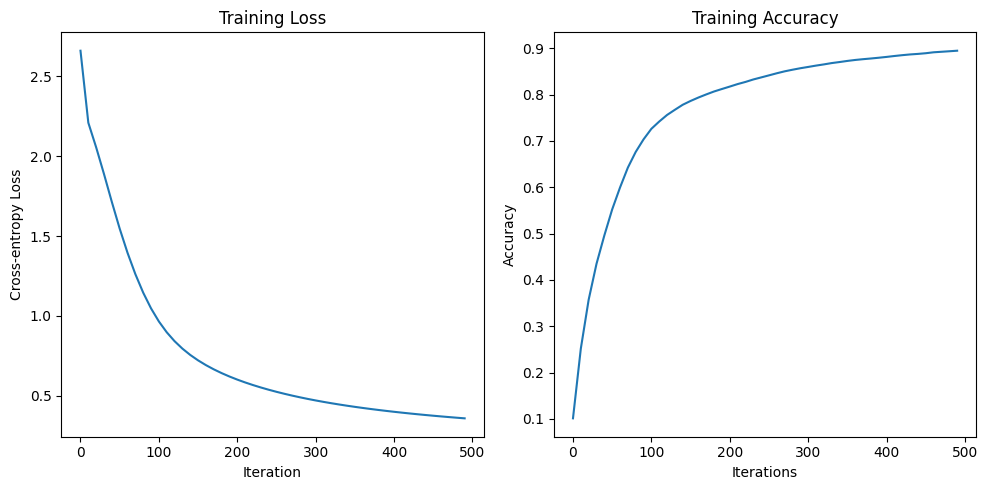

In [11]:
W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = gradient_descent(X_train, Y_train, 0.10, 500)

# **Predictions vs Actual (Regular Gradient Descent)**

In [12]:
def make_predict(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    _, _, _, _, _, _, _, _, _, A5 = forward_prop(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
    predictions = np.argmax(A5, 0 )
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    current_image = X_train[:, index, None]
    prediction = make_predict(X_train[:, index, None], W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
    label = Y_train[index]
    print("Prediction:: ", prediction)
    print("Label: ", label)

    current_img = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction::  [4]
Label:  2


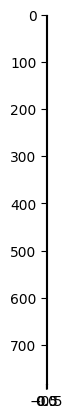

Prediction::  [4]
Label:  4


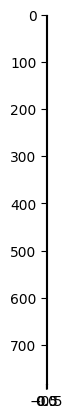

Prediction::  [8]
Label:  4


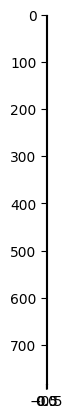

Prediction::  [4]
Label:  4


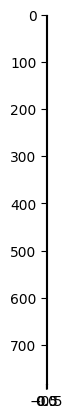

Prediction::  [7]
Label:  7


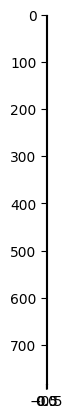

Prediction::  [7]
Label:  5


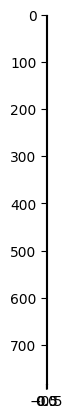

Prediction::  [3]
Label:  3


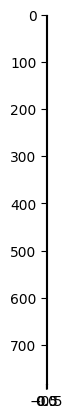

Prediction::  [0]
Label:  0


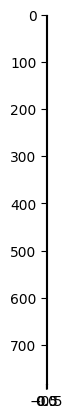

Prediction::  [0]
Label:  0


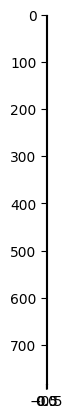

Prediction::  [8]
Label:  8


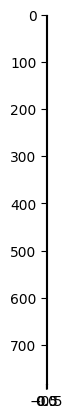

Prediction::  [9]
Label:  7


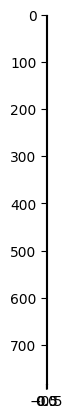

Prediction::  [3]
Label:  3


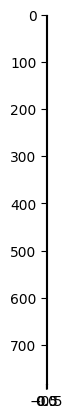

Prediction::  [1]
Label:  1


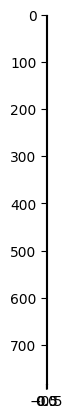

Prediction::  [7]
Label:  7


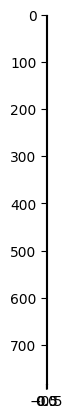

Prediction::  [9]
Label:  9


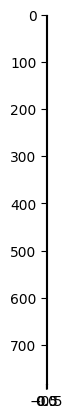

Prediction::  [9]
Label:  9


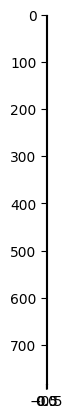

Prediction::  [9]
Label:  4


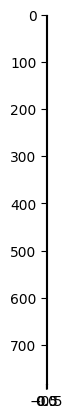

Prediction::  [1]
Label:  1


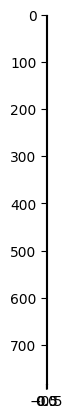

Prediction::  [8]
Label:  8


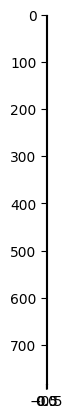

Prediction::  [0]
Label:  0


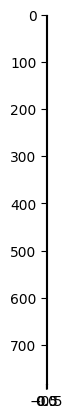

Prediction::  [4]
Label:  4


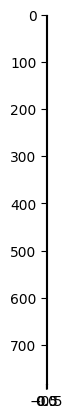

Prediction::  [2]
Label:  2


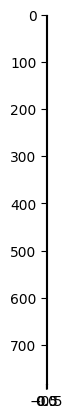

Prediction::  [9]
Label:  9


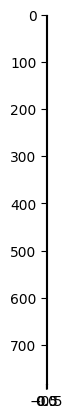

Prediction::  [7]
Label:  7


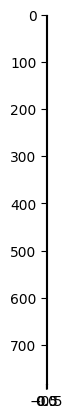

Prediction::  [0]
Label:  0


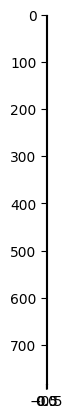

Prediction::  [0]
Label:  0


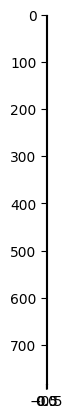

Prediction::  [5]
Label:  5


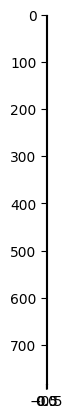

Prediction::  [2]
Label:  2


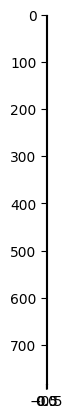

Prediction::  [0]
Label:  0


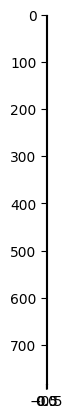

Prediction::  [6]
Label:  3


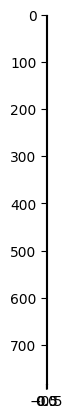

Prediction::  [7]
Label:  7


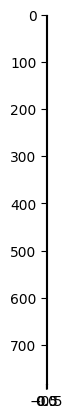

Prediction::  [5]
Label:  5


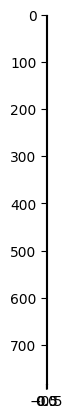

Prediction::  [9]
Label:  9


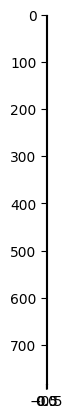

Prediction::  [8]
Label:  8


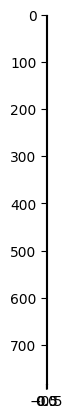

Prediction::  [1]
Label:  1


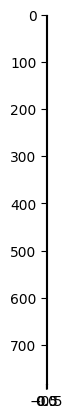

Prediction::  [1]
Label:  1


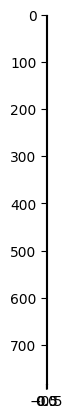

Prediction::  [9]
Label:  7


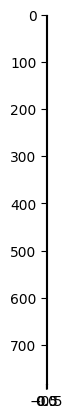

Prediction::  [1]
Label:  1


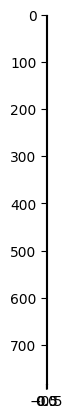

Prediction::  [7]
Label:  7


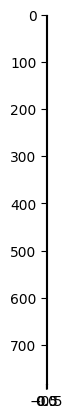

Prediction::  [3]
Label:  3


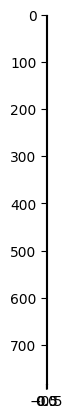

Prediction::  [7]
Label:  7


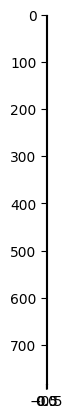

Prediction::  [0]
Label:  0


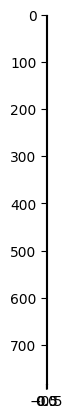

Prediction::  [9]
Label:  9


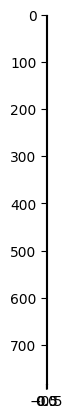

Prediction::  [3]
Label:  3


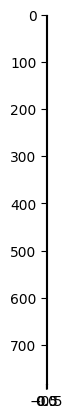

Prediction::  [9]
Label:  9


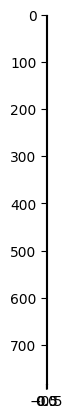

Prediction::  [9]
Label:  9


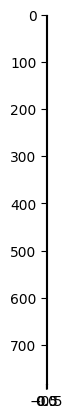

Prediction::  [0]
Label:  0


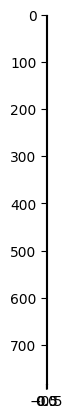

Prediction::  [8]
Label:  8


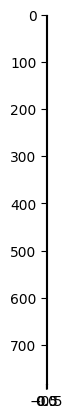

Prediction::  [3]
Label:  3


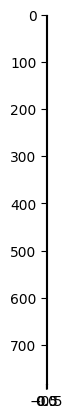

Prediction::  [5]
Label:  5


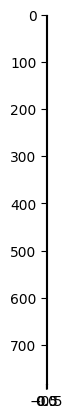

In [13]:
for i in range(0, 50):
    test_prediction(i, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)

# **Gradient Descent (With Adam Optimizer)**

[9 9 9 ... 0 9 9] [2 4 4 ... 2 6 4]
Iteration: 0, Accuracy: 0.14432, Loss: 2.56807
[1 7 7 ... 1 6 7] [2 4 4 ... 2 6 4]
Iteration: 10, Accuracy: 0.25702, Loss: 2.13565
[1 4 4 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 20, Accuracy: 0.56179, Loss: 1.82147
[6 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 30, Accuracy: 0.64226, Loss: 1.44124
[6 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 40, Accuracy: 0.70565, Loss: 1.09494
[6 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 50, Accuracy: 0.76440, Loss: 0.85597
[6 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 60, Accuracy: 0.80363, Loss: 0.69739
[6 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 70, Accuracy: 0.83342, Loss: 0.58636
[4 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 80, Accuracy: 0.85595, Loss: 0.50504
[4 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 90, Accuracy: 0.87119, Loss: 0.44548
[4 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 100, Accuracy: 0.88387, Loss: 0.40145
[4 4 9 ... 2 6 4] [2 4 4 ... 2 6 4]
Iteration: 110, Accuracy: 0.89292, Loss:

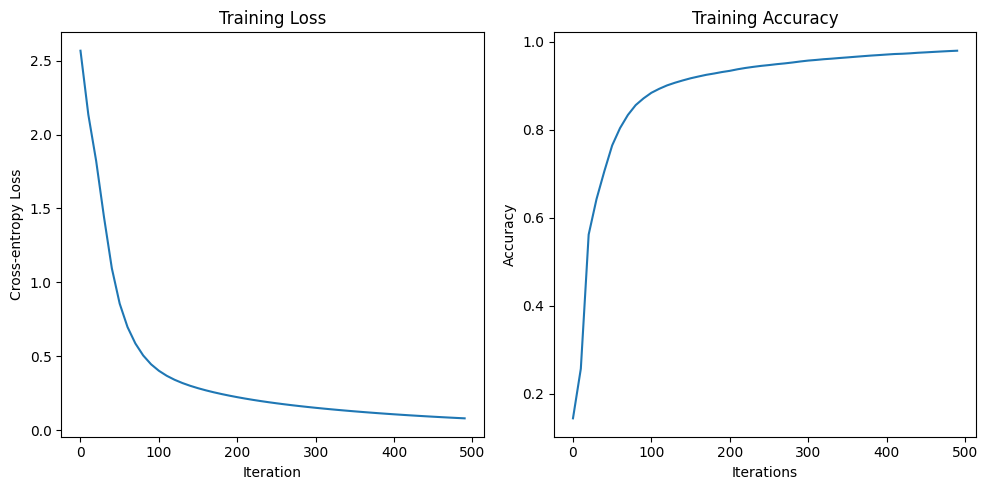

In [14]:
W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = gradient_descent_adam(X_train, Y_train, 0.001, 500)

# **Predictions vs Actual (Adam Gradient Descent)**

In [15]:
def make_predict(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    _, _, _, _, _, _, _, _, _, A5 = forward_prop(X, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
    predictions = np.argmax(A5, 0 )
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    current_image = X_train[:, index, None]
    prediction = make_predict(X_train[:, index, None], W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
    label = Y_train[index]
    print("Prediction:: ", prediction)
    print("Label: ", label)

    current_img = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction::  [2]
Label:  2


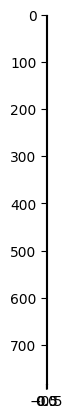

Prediction::  [4]
Label:  4


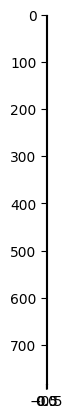

Prediction::  [4]
Label:  4


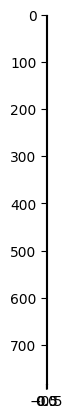

Prediction::  [4]
Label:  4


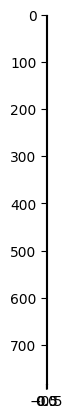

Prediction::  [7]
Label:  7


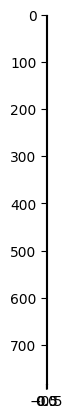

Prediction::  [5]
Label:  5


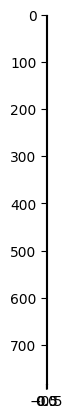

Prediction::  [3]
Label:  3


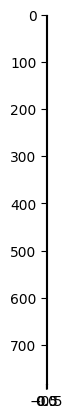

Prediction::  [0]
Label:  0


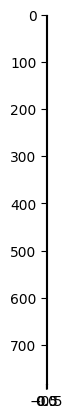

Prediction::  [0]
Label:  0


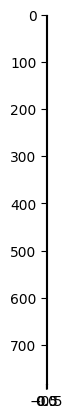

Prediction::  [8]
Label:  8


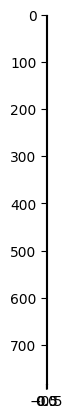

Prediction::  [7]
Label:  7


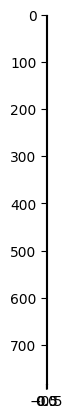

Prediction::  [3]
Label:  3


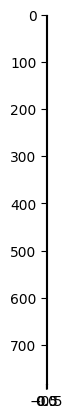

Prediction::  [1]
Label:  1


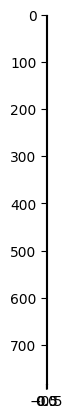

Prediction::  [7]
Label:  7


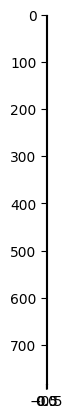

Prediction::  [9]
Label:  9


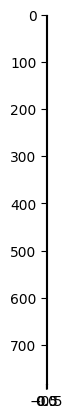

Prediction::  [9]
Label:  9


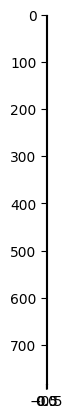

Prediction::  [4]
Label:  4


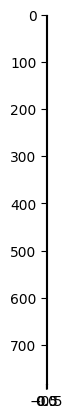

Prediction::  [1]
Label:  1


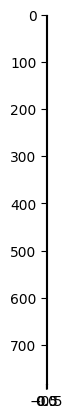

Prediction::  [8]
Label:  8


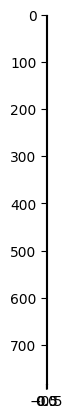

Prediction::  [0]
Label:  0


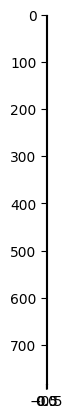

Prediction::  [4]
Label:  4


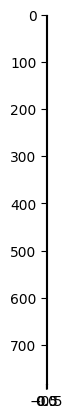

Prediction::  [2]
Label:  2


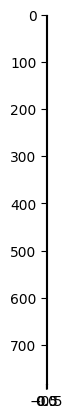

Prediction::  [9]
Label:  9


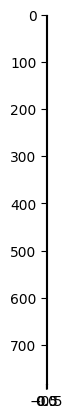

Prediction::  [7]
Label:  7


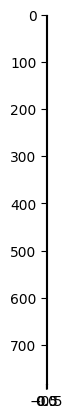

Prediction::  [0]
Label:  0


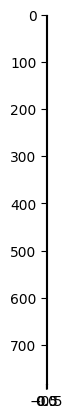

Prediction::  [0]
Label:  0


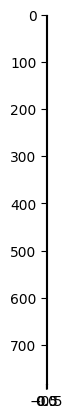

Prediction::  [5]
Label:  5


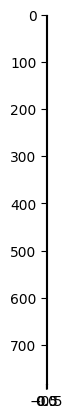

Prediction::  [2]
Label:  2


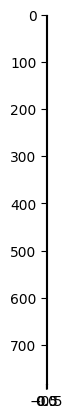

Prediction::  [0]
Label:  0


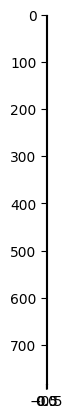

Prediction::  [3]
Label:  3


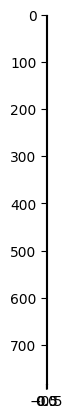

Prediction::  [7]
Label:  7


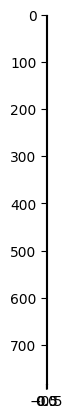

Prediction::  [5]
Label:  5


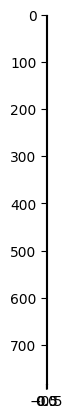

Prediction::  [9]
Label:  9


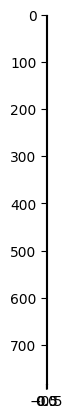

Prediction::  [8]
Label:  8


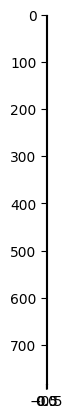

Prediction::  [1]
Label:  1


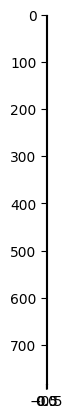

Prediction::  [1]
Label:  1


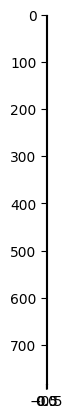

Prediction::  [7]
Label:  7


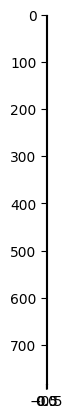

Prediction::  [1]
Label:  1


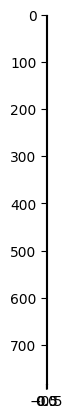

Prediction::  [7]
Label:  7


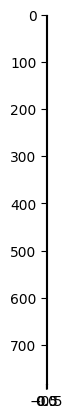

Prediction::  [3]
Label:  3


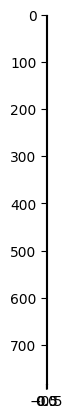

Prediction::  [7]
Label:  7


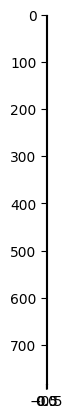

Prediction::  [0]
Label:  0


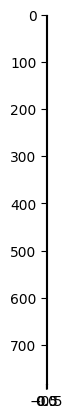

Prediction::  [9]
Label:  9


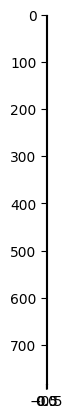

Prediction::  [3]
Label:  3


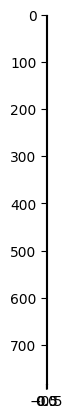

Prediction::  [9]
Label:  9


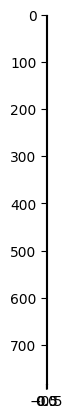

Prediction::  [9]
Label:  9


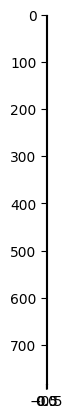

Prediction::  [0]
Label:  0


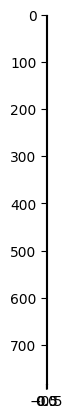

Prediction::  [8]
Label:  8


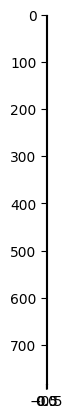

Prediction::  [3]
Label:  3


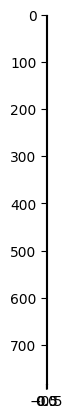

Prediction::  [5]
Label:  5


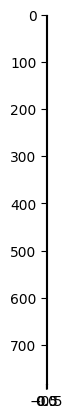

In [16]:
for i in range(0, 50):
    test_prediction(i, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)

In [17]:
dev_predictions = make_predict(X_test, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
get_accuracy(dev_predictions, Y_test)

[7 0 3 ... 0 6 6] [2 0 7 ... 0 6 6]


0.9541666666666667

The predictions vs the actual values are actually working which is good.

# **Conclusion**

In summary, the high training accuracy of 98% coupled with a minimal loss of 0.07 strongly suggests overfitting in our model. While exploring various learning rates (0.01, 0.1, and others), a learning rate of 0.001 yielded the most favorable training outcome. Furthermore, the architecture of the network, specifically the dimensionality of the input, hidden, and output layers, significantly influenced the results. As anticipated, increasing the number of training iterations also contributed to the observed overfitting.

When comparing the performance of standard gradient descent to gradient descent utilizing the Adam optimizer, a notable 9% difference in accuracy (89% versus 98%) was observed. Even when considering the impact of overfitting and other architectural choices, this substantial improvement underscores the effectiveness of the Adam optimizer in enhancing the optimization process.

